# Read the File


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local[*]").appName("nyc").getOrCreate()

df = spark.read.option("header", True).csv("nyc-jobs.csv")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/19 15:06:17 WARN Utils: Your hostname, Earams-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.29.11 instead (on interface en0)
26/02/19 15:06:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/19 15:06:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/19 15:06:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/02/19 15:06:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/02/19 15:06:18 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Cleaning the Data

In [3]:
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show(vertical=True, truncate=False)

26/02/19 15:06:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Location 1               | 1138 
 Recruitment Contact           | 1763 
 Residency Requirement         | 678  
 Posting Date            

In [4]:
def clean_column_names(df):
    for c in df.columns:
        new_col = (
            c.strip()
             .lower()
             .replace(" ", "_")
             .replace("-", "_")
             .replace("/", "_")
             .replace("(", "")
             .replace(")", "")
        )
        df = df.withColumnRenamed(c, new_col)
    return df

# Calculate average salary

In [10]:
from pyspark.sql.types import DoubleType
def add_salary_features(df):
    """
    Cast salary columns to numeric and compute average salary.

    Args:
        df (pyspark.sql.DataFrame): Raw jobs DataFrame.

    Returns:
        pyspark.sql.DataFrame: DataFrame with salary_from, salary_to and avg_salary.
    """

    df = df.withColumn("salary_from", col("Salary Range From").cast(DoubleType())) \
           .withColumn("salary_to", col("Salary Range To").cast(DoubleType()))

    df = df.withColumn(
        "avg_salary",
        (col("salary_from") + col("salary_to")) / 2
    )

    return df


In [11]:
df = add_salary_features(df)
df.show(5)

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+----------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recr

In [6]:
df.show()

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Require

# Whats the number of jobs posting per category (Top 10)?

In [21]:
from pyspark.sql.functions import desc

kpi1 = df.groupBy("Job Category") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10)

#kpi1.show()


+--------------------+-----+
|        Job Category|count|
+--------------------+-----+
|Engineering, Arch...|  504|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Building Operatio...|  181|
|Finance, Accounti...|  169|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+



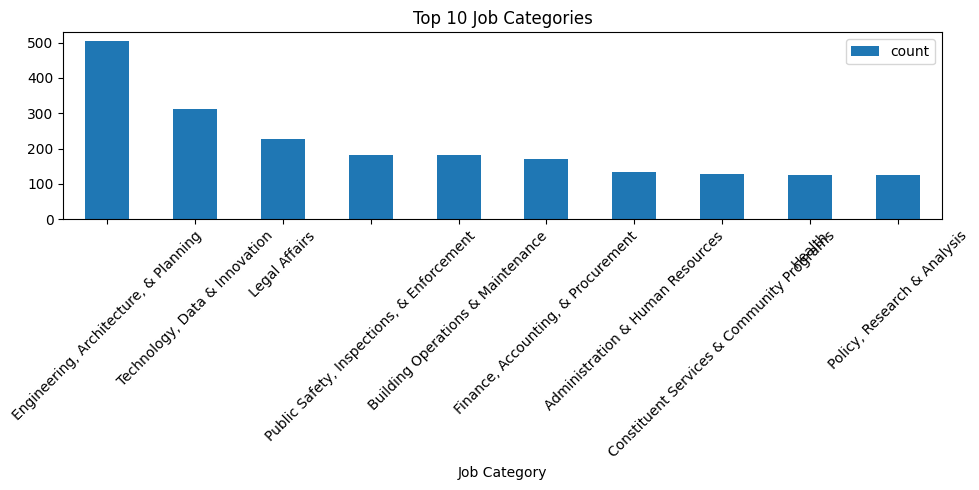

In [23]:
pdf = kpi1.toPandas()

import matplotlib.pyplot as plt

pdf.plot(kind="bar", x="Job Category", y="count", figsize=(10,5))
plt.title("Top 10 Job Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Whats the salary distribution per job category?¶

In [25]:
from pyspark.sql.functions import avg, min, max, count

kpi2 = df.groupBy("Job Category") \
    .agg(
        avg("avg_salary").alias("avg_salary"),
        min("avg_salary").alias("min_salary"),
        max("avg_salary").alias("max_salary"),
        count("*").alias("job_count")
    ) \
    .orderBy(desc("avg_salary"))

#kpi2.show()


+--------------------+------------------+----------+----------+---------+
|        Job Category|        avg_salary|min_salary|max_salary|job_count|
+--------------------+------------------+----------+----------+---------+
|Administration & ...|          218587.0|  218587.0|  218587.0|        2|
|Engineering, Arch...|          198518.0|  198518.0|  198518.0|        2|
|Engineering, Arch...|          196042.5|  182500.0|  209585.0|        4|
|Health Policy, Re...|          128694.5|   94889.0|  162500.0|        4|
|Engineering, Arch...|          128247.5|  128247.5|  128247.5|        2|
|Engineering, Arch...|          128247.5|  128247.5|  128247.5|        2|
|Communications & ...|          125000.0|  125000.0|  125000.0|        2|
|Administration & ...|          118287.0|  118287.0|  118287.0|        2|
|Constituent Servi...|116900.33333333333|   58500.0|  217201.0|        6|
|Constituent Servi...|          103680.5|  103680.5|  103680.5|        2|
|Technology, Data ...|          96373.

/var/folders/bk/1fqtcp393hg4vk283td1b1w00000gn/T/ipykernel_87353/1946706239.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


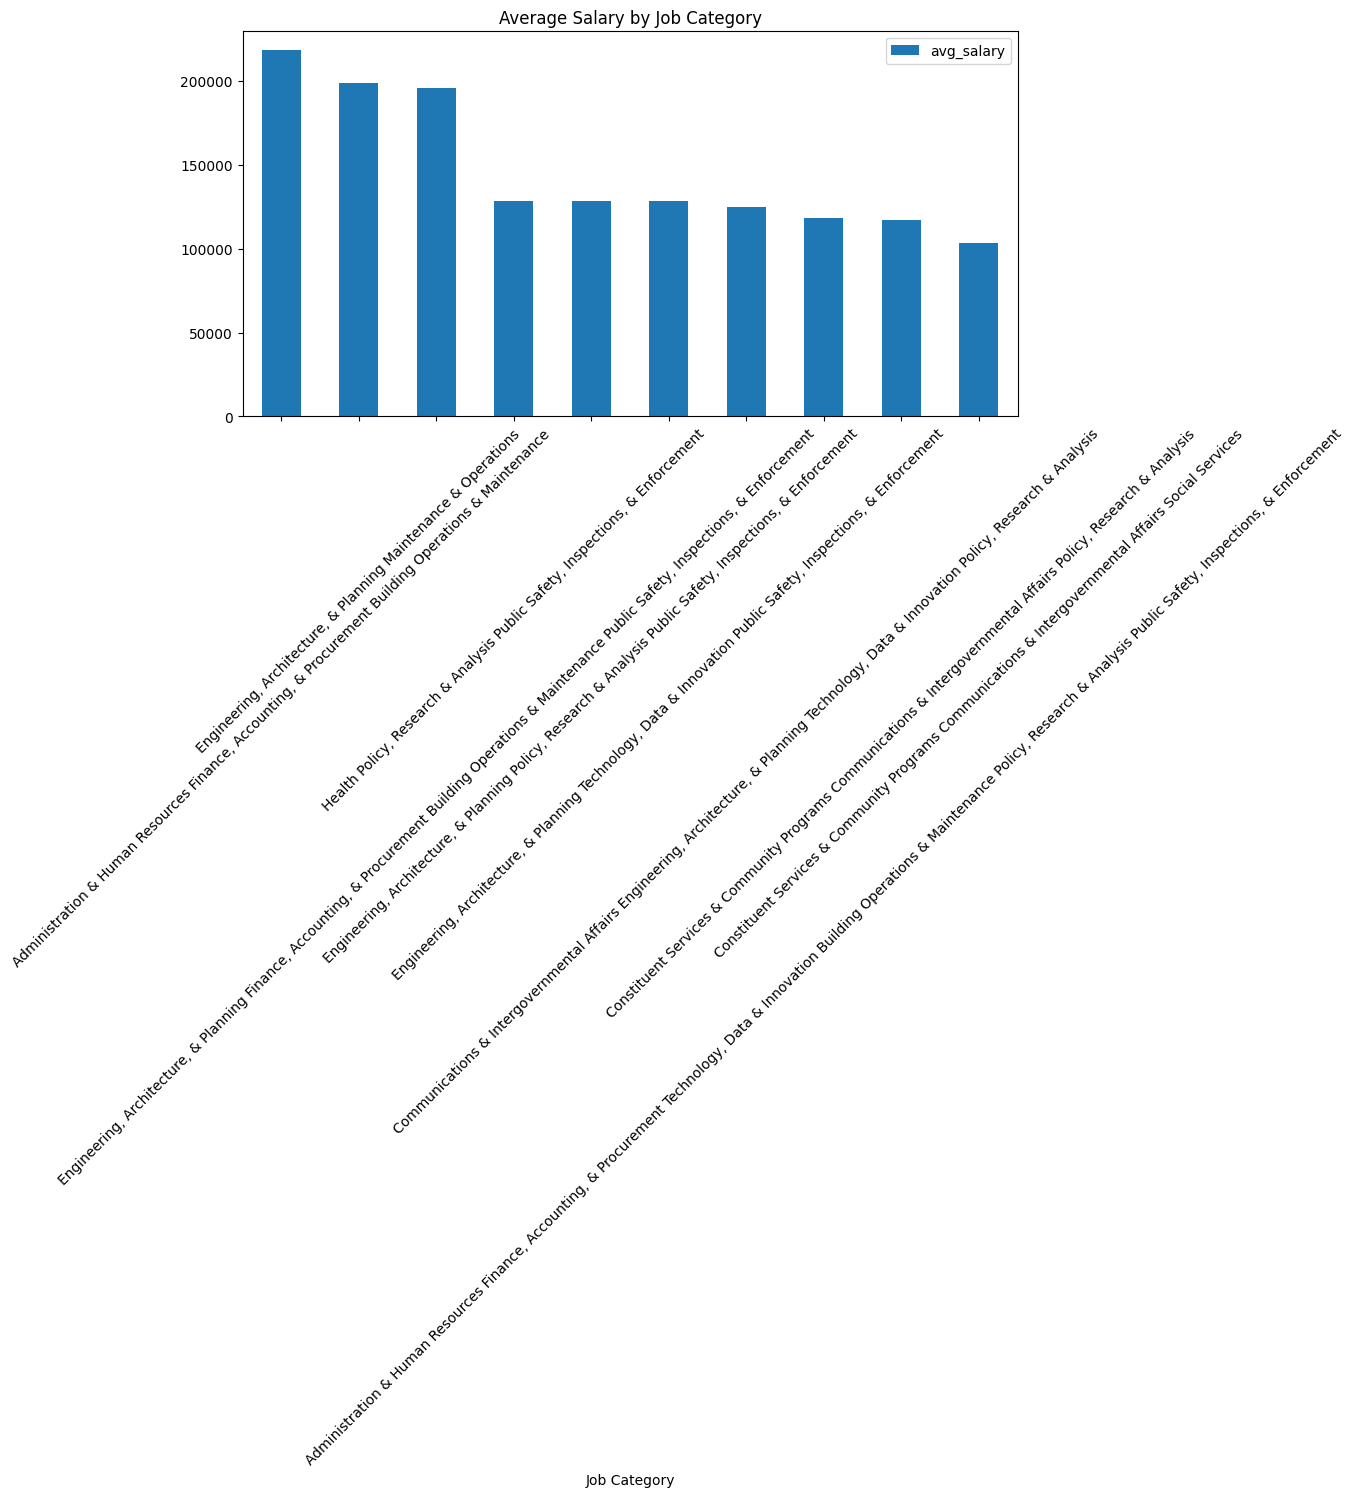

In [26]:
pdf = kpi2.limit(10).toPandas()

pdf.plot(kind="bar", x="Job Category", y="avg_salary", figsize=(10,5))
plt.title("Average Salary by Job Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Is there any correlation between the higher degree and the salary?

In [29]:
from pyspark.sql.functions import lower, when, col

df = df.withColumn(
    "degree_flag",
    when(
        lower(col("Minimum Qual Requirements")).contains("degree"),
        1
    ).otherwise(0)
)


In [30]:
corr = df.select("degree_flag", "avg_salary") \
    .dropna() \
    .stat.corr("degree_flag", "avg_salary")

print("Correlation:", corr)


Correlation: 0.25892550441387424


# Whats the job posting having the highest salary per agency?

In [14]:
def add_salary_bucket(df):
    """
    Categorize salaries into low / mid / high buckets.
    """

    df = df.withColumn(
        "salary_bucket",
        when(col("annual_salary") < 60000, "low")
        .when(col("annual_salary") < 100000, "mid")
        .otherwise("high")
    )

    return df


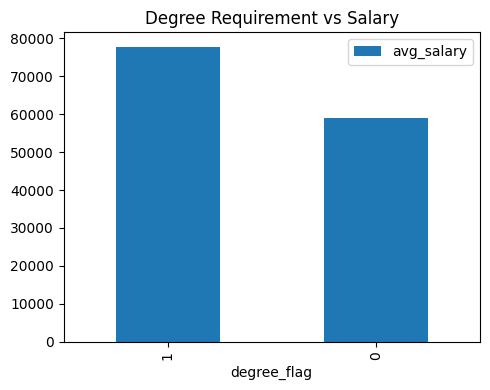

In [31]:
degree_salary = df.groupBy("degree_flag") \
    .agg(avg("avg_salary").alias("avg_salary"))

pdf = degree_salary.toPandas()

pdf.plot(kind="bar", x="degree_flag", y="avg_salary", figsize=(5,4))
plt.title("Degree Requirement vs Salary")
plt.tight_layout()
plt.show()


In [32]:
kpi4 = df.groupBy("agency") \
    .agg(max("avg_salary").alias("highest_salary")) \
    .orderBy(desc("highest_salary")) \
    .limit(10)

#kpi4.show()




+--------------------+--------------+
|              agency|highest_salary|
+--------------------+--------------+
|DEPT OF ENVIRONME...|      218587.0|
|   POLICE DEPARTMENT|      217201.0|
|DISTRICT ATTORNEY...|      191913.0|
|NYC HOUSING AUTHO...|      180000.0|
|NYC EMPLOYEES RET...|      177374.5|
|DEPT OF HEALTH/ME...|     170133.84|
|OFFICE OF THE COM...|      167500.0|
|DEPARTMENT OF INV...|      165000.0|
|      LAW DEPARTMENT|      164104.0|
|DEPT OF DESIGN & ...|      151795.0|
+--------------------+--------------+



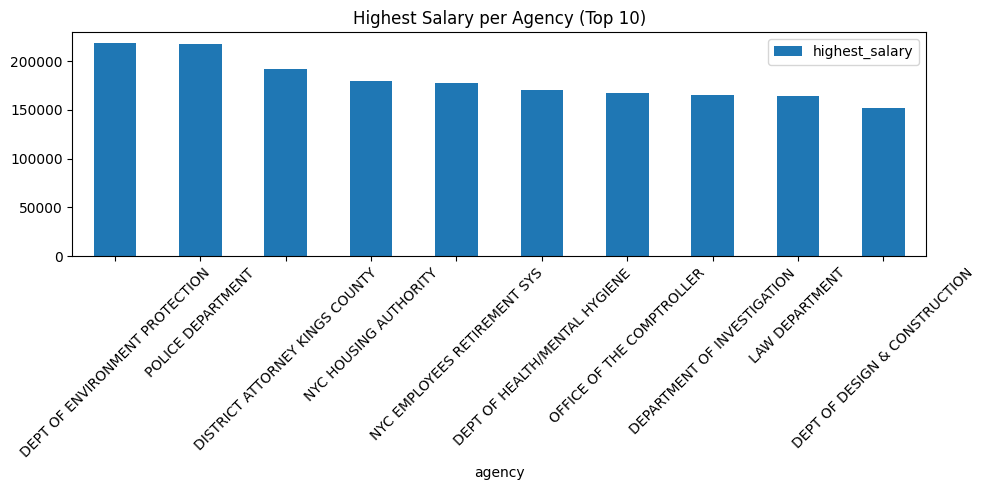

In [33]:
pdf = kpi4.toPandas()

pdf.plot(kind="bar", x="agency", y="highest_salary", figsize=(10,5))
plt.title("Highest Salary per Agency (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Whats the job positings average salary per agency for the last 2 years?

In [ ]:
from pyspark.sql.functions import to_date, year, col

df_clean = df.withColumn(
    "posting_date",
    to_date(col("Posting Date"))
)

df_clean = df.withColumn(
    "posting_year",
    year(col("posting_date"))
)

In [37]:
from pyspark.sql.functions import regexp_extract, when, length, col

df = df.withColumn(
    "posting_year_raw",
    regexp_extract(col("Posting Date"), r'(\d{4})', 1)
)

df = df.withColumn(
    "posting_year",
    when(length(col("posting_year_raw")) > 0, col("posting_year_raw").cast("int"))
    .otherwise(None)
)


In [9]:
df.show()

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+----------+------------+----------+----------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|      

In [48]:
kpi_5 = df.filter(col("posting_year") >= 2024)

kpi_5.groupBy("Agency") \
      .agg(avg("avg_salary").alias("avg_salarylast_2yrs")) \
      .show()


+--------------------+-------------------+
|              Agency|avg_salarylast_2yrs|
+--------------------+-------------------+
|DEPT OF HEALTH/ME...|           74968.25|
|DEPT OF DESIGN & ...|            80526.5|
|CIVILIAN COMPLAIN...|            27.1355|
|DEPT OF ENVIRONME...|            89349.0|
|DEPT OF CITYWIDE ...|            78804.5|
|DEPARTMENT OF TRA...|           61358.25|
|DEPT OF INFO TECH...|           117470.0|
|DEPT OF YOUTH & C...|            54744.0|
|DEPARTMENT OF INV...|            63024.5|
|LANDMARKS PRESERV...|            60103.5|
|   POLICE DEPARTMENT|            54402.0|
+--------------------+-------------------+



In [ ]:
pdf = kpi_5.toPandas()

import matplotlib.pyplot as plt

pdf.plot(kind="bar", x="Agency", y="avg_salarylast_2yrs", figsize=(10,5))
plt.title("Average Salary per Agency (Last 2 Years)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
skills_df = df.withColumn(
    "skill",
    explode(split(col("Preferred Skills"), ","))
)

skills_df = skills_df.withColumn("skill", trim(lower(col("skill"))))

top_skills = skills_df.groupBy("skill").agg(avg("avg_salary").alias("avg_salary")).orderBy(desc("avg_salary")).limit(10)

top_skills.show()

+--------------------+----------+
|               skill|avg_salary|
+--------------------+----------+
|he/she must be an...|  218587.0|
|and implement act...|  218587.0|
|   diagnose problems|  218587.0|
|and implementing ...|  218587.0|
|of which at least...|  218587.0|
|the following ski...|  218587.0|
|develop and retai...|  218587.0|
|city and state go...|  218587.0|
|continuous improv...|  218587.0|
|communication and...|  218587.0|
+--------------------+----------+



In [19]:
from pyspark.sql.functions import col, when, lower, regexp_extract

def clean_salary(df):
    df = df.withColumn("salary_from", col("Salary Range From").cast("double")) \
           .withColumn("salary_to", col("Salary Range To").cast("double"))
    df= df.withColumn("avg_salary", (col("salary_from") + col("salary_to")) / 2)
    
    return df

def extract_posting_year(df):
    df = df.withColumn("posting_year_raw",
                       regexp_extract(col("Posting Date"), r'(\d{4})', 1))
    df= df.withColumn(
        "posting_year",
        when(col("posting_year_raw") != "", col("posting_year_raw").cast("int"))
        .otherwise(None)
    )
    return df
    

def add_degree_flag(df):
    df=df.withColumn(
        "has_degree",
        when(lower(col("Minimum Qual Requirements")).contains("degree"),1).otherwise(0)
    )
    return df
    


In [50]:
df = df.withColumn(
    "salary_bucket",
    when(col("avg_salary") >= 100000, "High")
    .when(col("avg_salary") >= 50000, "Medium")
    .otherwise("Low")
).show()


+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------+---------+----------+-----------+----------------+------------+-------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            

In [22]:
df = df.drop("Job Description")


In [23]:
df.write.mode("overwrite").parquet("nyc_job_processed")


In [ ]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

In [ ]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result

In [48]:
assert df.filter(col("avg_salary").isNull()).count() == 0


ConnectionRefusedError: [Errno 61] Connection refused

In [13]:
pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 4.0 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 3.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.9 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 3.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.9 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


# Basic Assert test

In [ ]:
# Dataset should not be empty
assert df.count() > 0

# avg_salary must exist
assert "avg_salary" in df.columns

# posting_year must exist
assert "posting_year" in df.columns

sample = df.select("avg_salary").dropna().limit(5).collect()
assert all([row.avg_salary > 0 for row in sample])



# deployment

I have deployed it on my local since I have local set up